## merging polygons & points PA

In [41]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# Load the wind suitability raster
power_den_path = r"C:\Users\mun93\Downloads\wind_suitability_final.tif"
with rasterio.open(power_den_path) as src:
    wind_raster = src.read(1)
    profile = src.profile  # Save metadata (CRS, transform, etc.)

# Load protected areas shapefile
#protected_area_path = r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp"
protected_area_path = r"C:\Users\mun93\Downloads\merged_WDPA_polygons.shp"
protected_areas = gpd.read_file(protected_area_path)

# Ensure both datasets are in the same CRS
protected_areas = protected_areas.to_crs(profile['crs'])

# Rasterize the protected areas (create a mask where 1=protected, 0=unprotected)
protected_mask = rasterize(
    shapes=protected_areas.geometry,
    out_shape=wind_raster.shape,
    transform=profile['transform'],
    fill=0,  # Background value (unprotected)
    all_touched=True  # Include all pixels touched by polygons
)

# Apply the mask: set wind suitability to NoData where protected_mask == 1
wind_raster_masked = np.where(protected_mask == 1, profile['nodata'], wind_raster)

# Save the result
output_path = r"C:\Users\mun93\Downloads\wind_suitability_polygons_masked.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(wind_raster_masked, 1)

print("Masked raster saved successfully!")


Masked raster saved successfully!


In [42]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# Load the wind suitability raster
power_den_path = r"C:\Users\mun93\Downloads\wind_suitability_polygons_masked.tif"
with rasterio.open(power_den_path) as src:
    wind_raster = src.read(1)
    profile = src.profile  # Save metadata (CRS, transform, etc.)

# Load protected areas shapefile
#protected_area_path = r"C:\Users\mun93\Downloads\WDPA_WDOECM_Apr2025_Public_DEU_shp\WDPA_WDOECM_Apr2025_Public_DEU_shp_2\WDPA_WDOECM_Apr2025_Public_DEU_shp-polygons.shp"
protected_area_path = r"C:\Users\mun93\Downloads\merged_WDPA_points.shp"
protected_areas = gpd.read_file(protected_area_path)

# Ensure both datasets are in the same CRS
protected_areas = protected_areas.to_crs(profile['crs'])

# Rasterize the protected areas (create a mask where 1=protected, 0=unprotected)
protected_mask = rasterize(
    shapes=protected_areas.geometry,
    out_shape=wind_raster.shape,
    transform=profile['transform'],
    fill=0,  # Background value (unprotected)
    all_touched=True  # Include all pixels touched by polygons
)

# Apply the mask: set wind suitability to NoData where protected_mask == 1
wind_raster_masked = np.where(protected_mask == 1, profile['nodata'], wind_raster)

# Save the result
output_path = r"C:\Users\mun93\Downloads\wind_suitability_polygons_and_points_masked.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(wind_raster_masked, 1)

print("Masked stage #2 raster saved successfully!")


Masked stage #2 raster saved successfully!


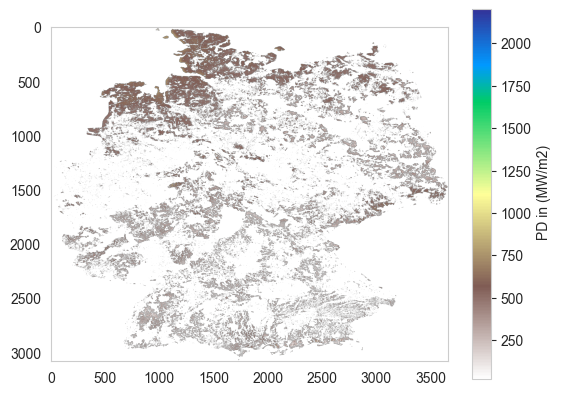

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Mask slopes >20° as NaN (transparent)
#PD_LC_PA_masked = np.where(wind_raster_masked )

plt.imshow(
    wind_raster_masked,
    cmap='terrain_r',  # Color map for slopes ≤20°
    #vmin=0,           # Minimum slope (0°)
    #vmax=20,          # Maximum slope to display (20°)
)
plt.colorbar(label=' PD in (MW/m2)')
#plt.title('Slope Map (Slopes >20° Blanked)')
plt.grid(False)
plt.show()



In [44]:
import numpy as np
import rasterio
from geopy.distance import geodesic
import math

# Constants
BETZ_LIMIT = 0.593  # Maximum theoretical efficiency
TURBINE_EFFICIENCY = 0.40 * 0.85 # Real-world turbine efficiency (35-45%), including BETZ_LIMIT
TURBINE_SPACING = 800  # meters between turbines (industry standard)
ROTOR_DIAMETER = 150  # meters (typical modern turbine)
ROTOR_AREA = math.pi * (ROTOR_DIAMETER/2)**2  # 17,671 m²

GERMANY_AREA_KM2 = 356888.69  # Total area of Germany
CAPACITY_FACTOR = 0.267     # 25% capacity factor for German onshore wind
HOURS_PER_YEAR = 8760

def calculate_wind_potential(raster_path):
    """Calculate realistic wind power potential from power density raster."""

    # 1. Load raster data
    with rasterio.open(raster_path) as src:
        power_density = src.read(1)  # Wind power density in W/m²
        crs = src.crs
        print(crs)
        transform = src.transform
        nodata = src.nodata

    # 2. Calculate pixel area in m²
    if crs.is_projected:
        # Projected CRS (units in meters)
        pixel_area_m2 = abs(transform.a * transform.e)
        print(f"Pixel size: {transform.a:.1f}m x {abs(transform.e):.1f}m")
    else:
        # Geographic CRS (WGS84 in degrees)
        left, top = transform * (0, 0)
        right, bottom = transform * (1, 1)
        pixel_width_m = geodesic((top, left), (top, right)).meters
        pixel_height_m = geodesic((top, left), (bottom, left)).meters
        pixel_area_m2 = pixel_width_m * pixel_height_m
        print(f"Pixel size: ~{pixel_width_m:.1f}m x ~{pixel_height_m:.1f}m (geographic)")

    # 3. Mask NoData values
    valid_data = np.where(power_density == nodata, np.nan, power_density) if nodata is not None else power_density

    # 4. Apply turbine physics
    # a) Account for Betz limit and turbine efficiency
    extractable_density = valid_data * TURBINE_EFFICIENCY

    # b) Account for turbine spacing (only ~7% of area has turbines)
    turbine_area_per_pixel = TURBINE_SPACING**2  # 250,000 m² per turbine
    area_utilization = ROTOR_AREA / turbine_area_per_pixel  # ~0.07

    # c) Calculate actual power generation per pixel
    operational_power = extractable_density * area_utilization

    # 5. Calculate total power (W)
    total_power_W = np.nansum(operational_power * pixel_area_m2)
    total_power_GW = total_power_W / 1e9  # Convert to GW
    potential_installed_capacity = total_power_GW/CAPACITY_FACTOR

    # 6. Calculate annual energy (TWh)
    annual_energy_TWh = (potential_installed_capacity * CAPACITY_FACTOR * HOURS_PER_YEAR) / 1e3

    # 7. Calculate suitable area
    valid_pixels = np.count_nonzero(~np.isnan(valid_data))
    suitable_area_km2 = (valid_pixels * pixel_area_m2) / 1e6

    # 8. Print results with reality checks
    print("\n=== Results ===")
    print(f"Suitable area: {suitable_area_km2:,.0f} km² ({suitable_area_km2/GERMANY_AREA_KM2:.1%} of Germany)")
    print(f"Total installed capacity: {total_power_GW:,.0f} GW")
    print(f"Total potential installed capacity per year: {potential_installed_capacity:,.0f} GW")
    print(f"Annual energy potential: {annual_energy_TWh:,.0f} TWh/year (at {CAPACITY_FACTOR:.0%} CF)")

    # Compare to known values
    print("\n=== Validation ===")
    print(f"Fraunhofer IEE Estimate: 1,100-2,900 TWh/year")
    print(f"German Consumption (2023): ~500 TWh/year")

    return {
        'suitable_area_km2': suitable_area_km2,
        'total_power_GW': total_power_GW,
        'potential_installed_capacity_GW': potential_installed_capacity,
        'annual_energy_TWh': annual_energy_TWh
    }

# Run calculation
results = calculate_wind_potential(r"C:\Users\mun93\Downloads\wind_suitability_polygons_and_points_masked.tif")

EPSG:4326
Pixel size: ~160.1m x ~278.3m (geographic)

=== Results ===
Suitable area: 27,686 km² (7.8% of Germany)
Total installed capacity: 131 GW
Total potential installed capacity per year: 491 GW
Annual energy potential: 1,149 TWh/year (at 27% CF)

=== Validation ===
Fraunhofer IEE Estimate: 1,100-2,900 TWh/year
German Consumption (2023): ~500 TWh/year


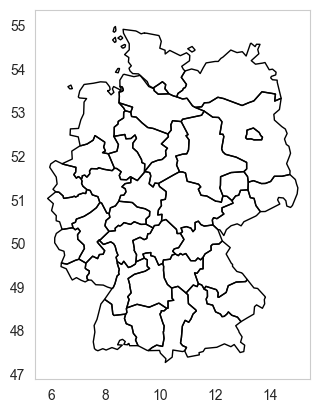

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

shpfile = r'C:\Users\mun93\Downloads\NUTS_RG_20M_2024_4326.shp\NUTS_RG_20M_2024_4326.shp'

DE_shape_file = gpd.read_file(shpfile)

DE2 = DE_shape_file[(DE_shape_file['NUTS_ID'].str.contains('DE')) & (DE_shape_file['LEVL_CODE'] == 2)]
DE2.plot(color='none', edgecolor='black')

plt.grid(False)
plt.show()


## ploting for the report


C:\Users\mun93\anaconda3\envs\JupyterProject_3.10\lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


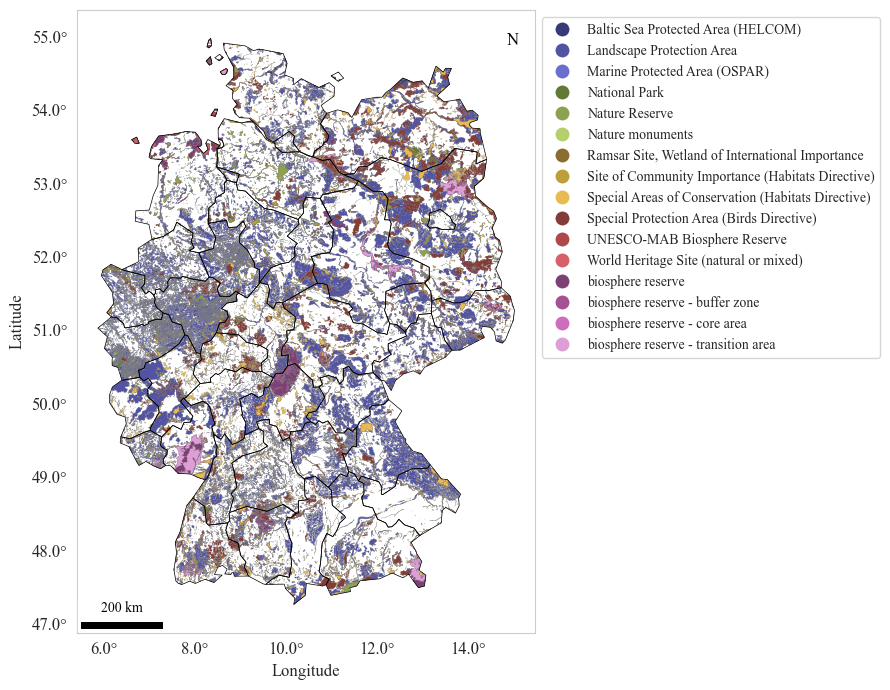

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as mticker
import geopandas as gpd
from rasterio.mask import mask

# Set the font to Times New Roman globally
plt.rcParams['font.family'] = 'Times New Roman'

# Path to the shapefile
shp_poly = r"C:\Users\mun93\Downloads\merged_WDPA_polygons.shp"

# Load shapefile data
shapefile_data = gpd.read_file(shp_poly)

# Load Germany shapefile - replace DE2 with actual path if not already loaded
# For example: nuts2_germany_shapefile = gpd.read_file("path_to_germany_shapefile.shp")
nuts2_germany_shapefile = DE2.copy()
nuts2_crs = nuts2_germany_shapefile.crs

# Reproject to match Germany CRS
#shapefile_data = shapefile_data.to_crs(nuts2_crs)

# Clip shapefile to Germany boundary
shapefile_data_clipped = gpd.clip(shapefile_data, nuts2_germany_shapefile)

# Create figure
fig, ax = plt.subplots(figsize=(9, 7))

# Plot the clipped shapefile
shapefile_data_clipped.plot(
    column='DESIG_ENG',
    ax=ax,
    edgecolor='grey',
    linewidth=0.1,
    cmap='tab20b',
    legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},

)

# Overlay Germany borders
nuts2_germany_shapefile.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Set title and remove grid
#ax.set_title("Protected Areas Clipped to Germany")
ax.grid(False)

# # Set bounds for consistent zoom
# ax.set_xlim(nuts2_germany_shapefile.total_bounds[[0, 2]])
# ax.set_ylim(nuts2_germany_shapefile.total_bounds[[1, 3]])

# Add a scale bar
scalebar = ScaleBar(111, "km", loc='lower left', scale_loc='top')
ax.add_artist(scalebar)

# Axes and layout
ax.set_xlabel("Longitude", fontsize=12)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}°"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.1f}°"))

# Add a north arrow
ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='center', va='center', color='black')

ax.set_ylabel("Latitude", fontsize=12)
ax.set_aspect('auto')
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)



plt.tight_layout()
plt.show()



## zonal statistics

In [13]:
zonal_sts = shapefile_data_clipped.copy()
#zonal_sts = zonal_sts.to_crs(epsg=32633)  # Replace with appropriate UTM CRS for your area
zonal_sts['Area'] = zonal_sts.geometry.to_crs(epsg=25832).area
zonal_sts.head()




,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry,Area
9981,378653.0,378653,1,Obersäckingen,Obersäckingen,Landschaftschutzgebiet,Landscape Protection Area,National,V,Not Applicable,...,Not Reported,State Verified,2013,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((7.9758 47.5659, 7.97569 47.56604, 7....",3.782101e+04
10001,325160.0,325160,1,Thimos,Thimos,Landschaftschutzgebiet,Landscape Protection Area,National,V,Not Applicable,...,Not Reported,State Verified,2013,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.01488 47.57387, 8.01506 47.57417, ...",5.247598e+05
10002,323101.0,323101,1,Murgtal,Murgtal,Landschaftschutzgebiet,Landscape Protection Area,National,V,Not Applicable,...,Not Reported,State Verified,2013,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.0026 47.61456, 8.00313 47.61464, 8...",2.437685e+06
10003,164873.0,164873,1,Oberer Schwarzenbach,Oberer Schwarzenbach,Naturschutzgebiet,Nature Reserve,National,IV,Not Applicable,...,Not Reported,State Verified,2013,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((7.97948 47.59233, 7.97963 47.5922, 7...",3.184077e+04
10004,81272.0,81272,1,Alter Weiher,Alter Weiher,Naturschutzgebiet,Nature Reserve,National,IV,Not Applicable,...,Not Reported,State Verified,2013,Not Reported,DEU,DEU,Not Applicable,Not Applicable,"POLYGON ((8.01833 47.61799, 8.01844 47.61795, ...",1.670817e+05


In [15]:
zonal_sts.PARENT_ISO.unique()

array(['DEU', 'DEU;SVK;ALB;AUT;BEL;BGR;ESP;HRV;ITA;ROU;SVN;UKR',
       'NLD;DEU;DNK'], dtype=object)

In [58]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [37]:
import seaborn as sns
tot_prot = zonal_sts.Area.sum()/1E6
area_grouped = zonal_sts.groupby(['DESIG_ENG'])['Area'].sum().div(1E6).sort_values(ascending=False).reset_index()
area_grouped['per%'] = area_grouped['Area'].div(tot_prot)*100

area_grouped

# sns.barplot(x='DESIG_ENG', y='per%', data=area_grouped)
# plt.xticks(rotation=90)



,DESIG_ENG,Area,per%
0,Landscape Protection Area,102116.960241,45.571273
1,Special Protection Area (Birds Directive),40031.042617,17.864472
2,Special Areas of Conservation (Habitats Direct...,31007.293822,13.837485
3,Nature Reserve,14394.520889,6.423778
4,biosphere reserve,14175.122426,6.325868
5,biosphere reserve - transition area,10225.291592,4.563195
6,biosphere reserve - buffer zone,3270.053746,1.459312
7,Site of Community Importance (Habitats Directive),2542.193465,1.134493
8,National Park,2003.596945,0.894136
9,"Ramsar Site, Wetland of International Importance",1741.363139,0.777110


C:\Users\mun93\AppData\Local\Temp\ipykernel_26036\2326547536.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20b', len(unique_labels))


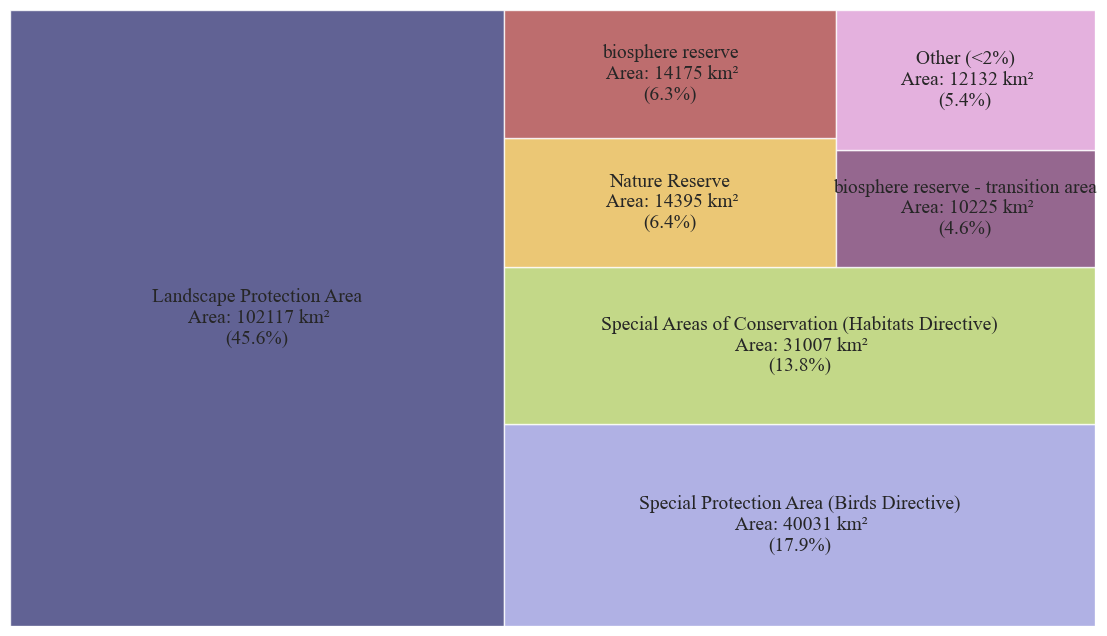

In [48]:
import matplotlib.pyplot as plt
import squarify
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

# Step 1: Threshold grouping
threshold = 2.0
major = area_grouped[area_grouped['per%'] >= threshold].copy()
minor = area_grouped[area_grouped['per%'] < threshold].copy()

# Step 2: Add "Other"
other_row = pd.DataFrame({
    'DESIG_ENG': ['Other (<2%)'],
    'Area': [minor['Area'].sum()],
    'per%': [minor['per%'].sum()]
})
df_plot = pd.concat([major, other_row], ignore_index=True)

# Step 3: Create color mapping from tab20b
unique_labels = df_plot['DESIG_ENG'].unique()
cmap = cm.get_cmap('tab20b', len(unique_labels))
color_dict = dict(zip(unique_labels, [mcolors.to_hex(cmap(i)) for i in range(len(unique_labels))]))

# Step 4: Map colors to rows
df_plot['color'] = df_plot['DESIG_ENG'].map(color_dict)

# Step 5: Plot treemap
labels = [
    f"{row['DESIG_ENG']}\n Area: {row['Area']:.0f} km²\n({row['per%']:.1f}%)"
    for _, row in df_plot.iterrows()

]

sizes = df_plot['Area'].tolist()
colors = df_plot['color'].tolist()

plt.figure(figsize=(14, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 14})
plt.axis('off')
#plt.title("Protected Areas Treemap (Color Matched to Map Legend)")
plt.show()


In [90]:
print(plt.colormaps())

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'berlin', 'managua', 'vanimo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 't

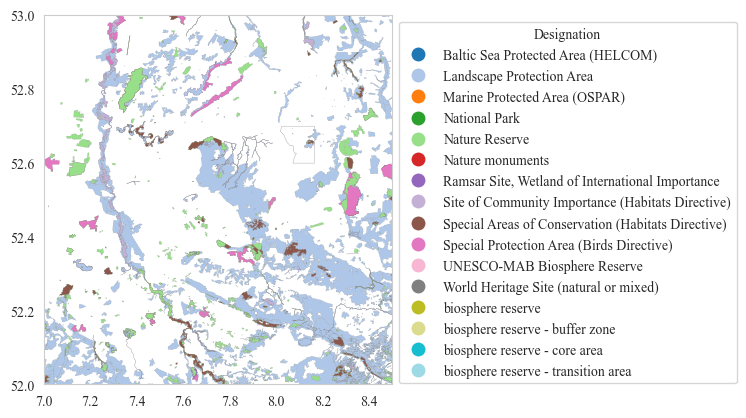

array(['Landscape Protection Area', 'Nature Reserve',
       'Special Areas of Conservation (Habitats Directive)',
       'Special Protection Area (Birds Directive)', 'biosphere reserve',
       'biosphere reserve - transition area',
       'biosphere reserve - core area', 'biosphere reserve - buffer zone',
       'National Park',
       'Site of Community Importance (Habitats Directive)',
       'World Heritage Site (natural or mixed)',
       'Ramsar Site, Wetland of International Importance',
       'Nature monuments', 'Baltic Sea Protected Area (HELCOM)',
       'Marine Protected Area (OSPAR)', 'UNESCO-MAB Biosphere Reserve'],
      dtype=object)

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
shapefile_data_clipped.plot(column='DESIG_ENG', edgecolor='grey', ax=ax, linewidth=0.1, cmap='tab20',
                             legend=True, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'title': 'Designation'})

# Set the limits (replace with your desired coordinates)
ax.set_xlim([7, 8.5])
ax.set_ylim([52, 54])

plt.grid(False)
plt.show()


shapefile_data_clipped.DESIG_ENG.unique()

In [33]:
from shapely.geometry import box
import geopandas as gpd

# Step 1: Create the bounding box in the same CRS as the data
bbox = box(7, 52, 8.5, 54)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326")  # Assuming your data is still in lat/lon

# Step 2: Clip your data to this bounding box
clipped_data = gpd.clip(shapefile_data_clipped, bbox_gdf)

# Step 3: Reproject to a metric CRS for area calculation
clipped_data = clipped_data.to_crs(epsg=32632)  # Or another suitable CRS

# Step 4: Calculate area in km²
clipped_data['area_km2'] = clipped_data.geometry.area / 1e6

# Step 5: Group and summarize by designation
area_by_designation = clipped_data.groupby('DESIG_ENG')['area_km2'].sum().sort_values(ascending=False)

# Step 6: Display or plot
print(area_by_designation)


DESIG_ENG
Landscape Protection Area                             3189.493877
Special Protection Area (Birds Directive)              959.368011
Nature Reserve                                         796.382277
biosphere reserve                                      743.907187
biosphere reserve - transition area                    612.448248
Special Areas of Conservation (Habitats Directive)     525.931505
Site of Community Importance (Habitats Directive)      240.093728
Ramsar Site, Wetland of International Importance       179.211626
National Park                                          133.056346
World Heritage Site (natural or mixed)                 131.860150
biosphere reserve - core area                          121.781542
UNESCO-MAB Biosphere Reserve                           115.584823
Marine Protected Area (OSPAR)                           91.471272
biosphere reserve - buffer zone                          9.616440
Name: area_km2, dtype: float64


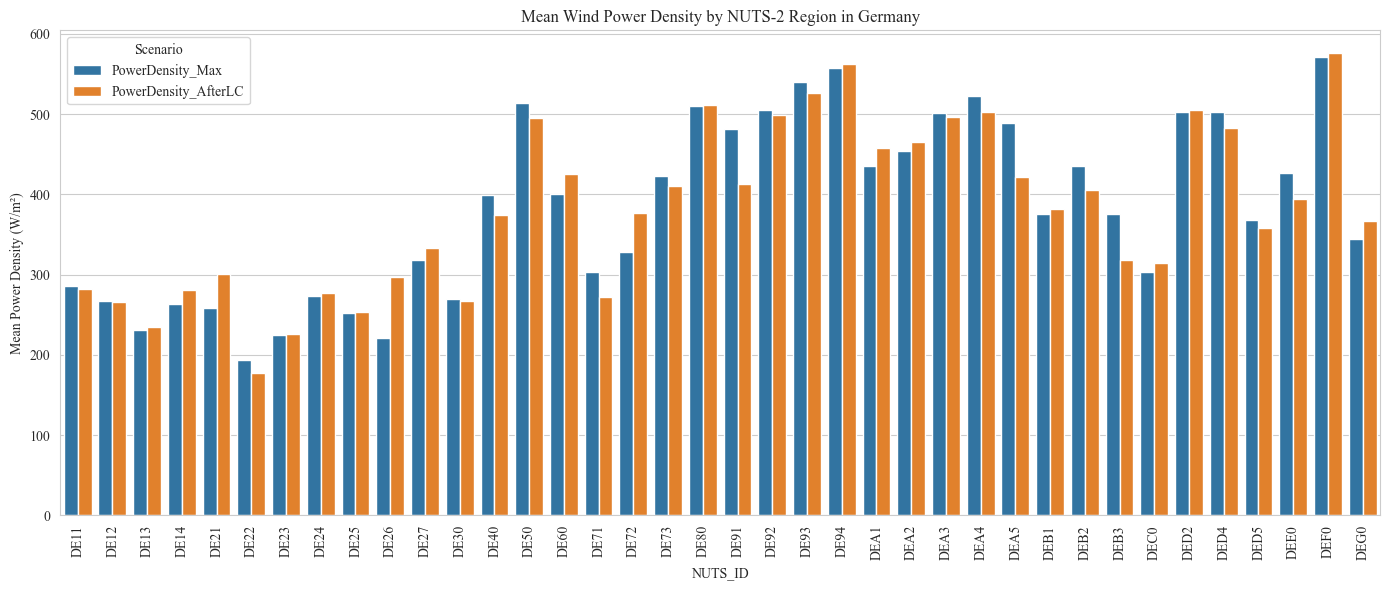

In [45]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

# Paths to input files
after_PA_path = r"C:\Users\mun93\Downloads\wind_suitability_polygons_and_points_masked.tif"
after_lc_path = r"C:\Users\mun93\Downloads\wind_suitability_final.tif"
shpfile = r'C:\Users\mun93\Downloads\NUTS_RG_20M_2024_4326.shp\NUTS_RG_20M_2024_4326.shp'

# Load shapefile and filter for Germany at NUTS level 2
DE_shape_file = gpd.read_file(shpfile)
DE2 = DE_shape_file[(DE_shape_file['NUTS_ID'].str.contains('DE')) & (DE_shape_file['LEVL_CODE'] == 2)]

# Compute zonal statistics for each raster
zonal_max = zonal_stats(DE2, after_PA_path, stats=["mean"], geojson_out=True)
zonal_after_lc = zonal_stats(DE2, after_lc_path, stats=["mean"], geojson_out=True)

# Extract NUTS_IDs and statistics
nuts_ids = [f["properties"]["NUTS_ID"] for f in zonal_max]
max_values = [f["properties"]["mean"] for f in zonal_max]
after_lc_values = [f["properties"]["mean"] for f in zonal_after_lc]

# Create DataFrame
df = pd.DataFrame({
    "NUTS_ID": nuts_ids,
    "PowerDensity_Max": max_values,
    "PowerDensity_AfterLC": after_lc_values
})

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars="NUTS_ID", value_vars=["PowerDensity_Max", "PowerDensity_AfterLC"],
                    var_name="Scenario", value_name="Mean Power Density (W/m²)")

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x="NUTS_ID", y="Mean Power Density (W/m²)", hue="Scenario")
plt.xticks(rotation=90)
plt.title("Mean Wind Power Density by NUTS-2 Region in Germany")
plt.tight_layout()
plt.show()


C:\Users\mun93\AppData\Local\Temp\ipykernel_32172\3593899231.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="Percent Drop", y="NUTS_ID", palette="Reds_d")


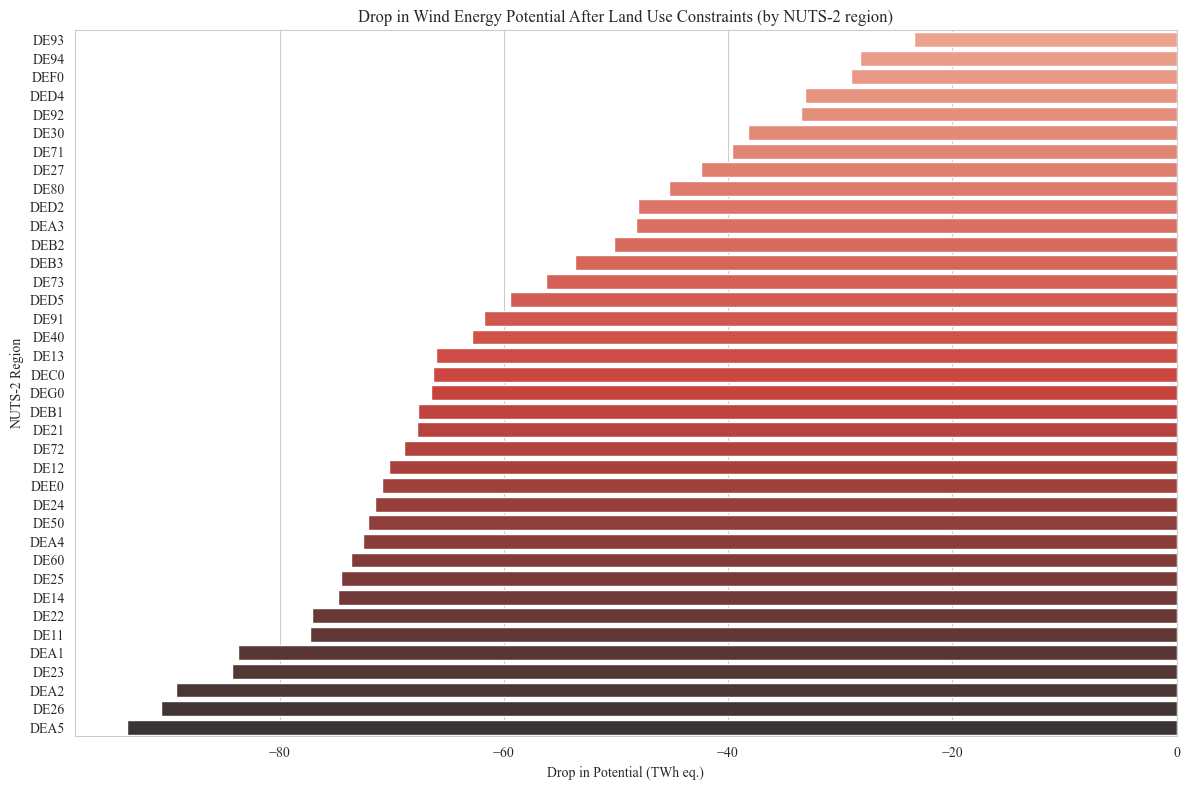

In [4]:
import geopandas as gpd
import rasterio
import rasterstats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Input files
max_potential_raster = r"C:\Users\mun93\Downloads\Power_density\DE_power_density_clipped.tif"
after_PA_path = r"C:\Users\mun93\Downloads\wind_suitability_polygons_and_points_masked.tif"
post_constraint_raster = r"C:\Users\mun93\Downloads\wind_suitability_final.tif"
shpfile = r'C:\Users\mun93\Downloads\NUTS_RG_20M_2024_4326.shp\NUTS_RG_20M_2024_4326.shp'

# Load NUTS-2 shapefile
DE_shape = gpd.read_file(shpfile)
DE2 = DE_shape[(DE_shape['NUTS_ID'].str.startswith('DE')) & (DE_shape['LEVL_CODE'] == 2)]

# Calculate zonal stats (sum of pixel values) for each raster
stats_max = rasterstats.zonal_stats(DE2, post_constraint_raster, stats="sum", geojson_out=True)
stats_after = rasterstats.zonal_stats(DE2, after_PA_path, stats="sum", geojson_out=True)

# Convert to DataFrame
data = []
for s_max, s_after in zip(stats_max, stats_after):
    nuts_id = s_max['properties']['NUTS_ID']
    region_name = s_max['properties'].get('NAME_LATN', nuts_id)
    val_max = s_max['properties']['sum']
    val_after = s_after['properties']['sum']
    drop = val_after - val_max
    pct_drop = ((val_after / val_max) - 1) * 100 if val_max else 0

    data.append({
        "NUTS_ID": nuts_id,
        "Region": region_name,
        "Before (TWh eq.)": val_max,
        "After (TWh eq.)": val_after,
        "Drop (TWh eq.)": drop,
        "Percent Drop": pct_drop
    })

df = pd.DataFrame(data)
df_sorted = df.sort_values(by="Percent Drop", ascending=False)

# Plot: Top impacted zones
plt.figure(figsize=(12, 8))
sns.barplot(data=df_sorted, x="Percent Drop", y="NUTS_ID", palette="Reds_d")
plt.title("Drop in Wind Energy Potential After Land Use Constraints (by NUTS-2 region)")
plt.xlabel("Drop in Potential (TWh eq.)")
plt.ylabel("NUTS-2 Region")
plt.tight_layout()
plt.show()


C:\Users\mun93\anaconda3\envs\JupyterProject_3.10\lib\site-packages\matplotlib_scalebar\scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


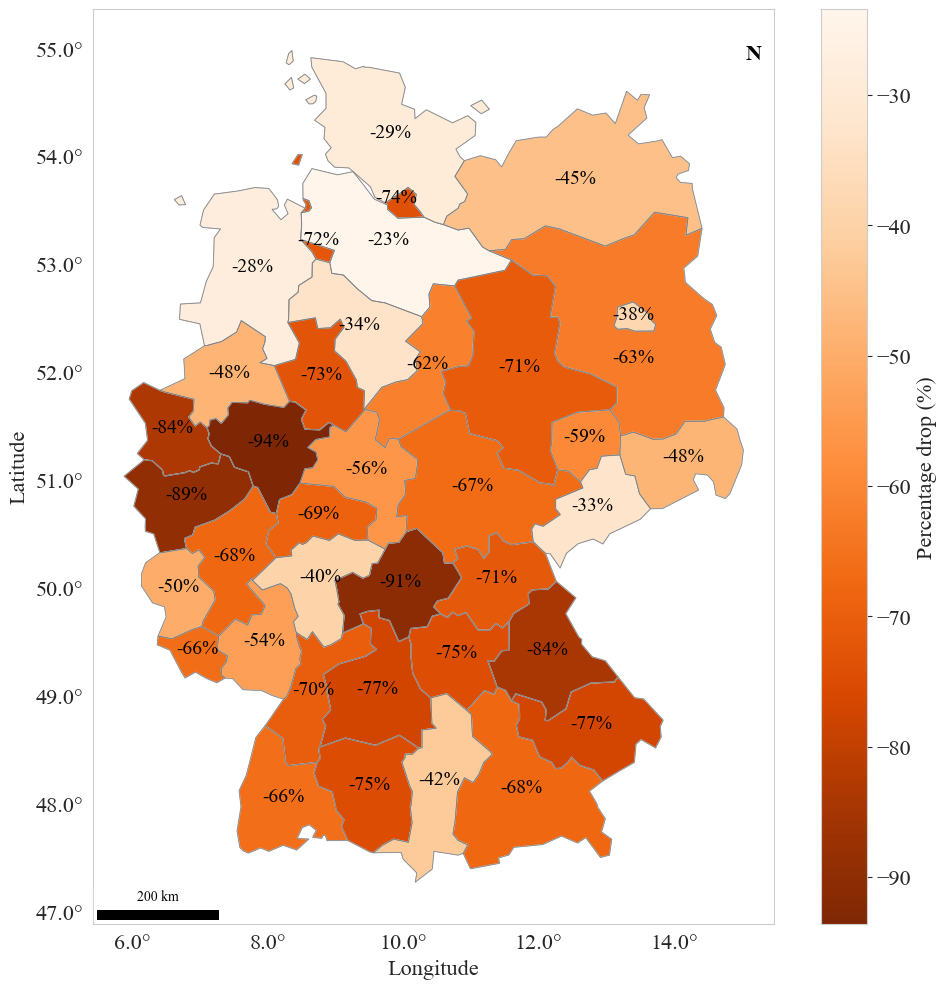

In [16]:
import matplotlib as plt
import matplotlib.ticker as mticker
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.cm as cm
import matplotlib.colors as colors

# Merge the percentage drop data back into the GeoDataFrame
DE2_with_drop = DE2.merge(df[["NUTS_ID", "Percent Drop"]], on="NUTS_ID")
DE2_with_drop['Percent Drop'] = DE2_with_drop['Percent Drop'].round(2)

plt.rcParams['font.family'] = 'Times New Roman'

# Plot the percentage drop on the map
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
DE2_with_drop.plot(column="Percent Drop",
                   cmap="Oranges_r",
                   linewidth=0.8,
                   ax=ax,
                   edgecolor="0.8",
                   #legend=True,
                   #legend_kwds={'label': "% Drop in Wind Energy Potential",
                                #'orientation': "vertical"}
)

#ax.set_title("Impact of Land Use Constraints on Wind Energy Potential (NUTS-2 Regions)", fontsize=14)

# Add annotations
for i, row in DE2_with_drop.iterrows():
    if row['NUTS_ID'] == 'DE40':
        xytext=(0, -30)
    else:
        xytext=(0, 0)

    plt.annotate(
        text=f"{row['Percent Drop']:.0f}%",
        xy=row.geometry.centroid.coords[0],
        ha='center',
        fontsize=14,
        xytext=xytext,  # Optional: Offset for text
        textcoords='offset points',
        color = 'k'

    )
DE2.boundary.plot(ax=ax, color='grey', linewidth=0.5)
# Add labels
ax.set_xlabel("Longitude", fontsize=16)
ax.set_ylabel("Latitude", fontsize=16)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.1f}°"))
ax.tick_params(axis='x', labelsize=16)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:.1f}°"))
ax.tick_params(axis='y', labelsize=16)
    # Add north arrow
ax.annotate('N', xy=(0.97, 0.95), xycoords='axes fraction',
            fontsize=16, ha='center', va='center', color='black', fontweight='bold')

scalebar = ScaleBar(111, "km", loc='lower left', scale_loc='top'#, length_fraction=0.25, border_pad=1, pad=0.5, frameon=None
                    )  # scale 1 = 1 unit in data CRS
ax.add_artist(scalebar)


# Normalize based on your data
norm = colors.Normalize(vmin=DE2_with_drop["Percent Drop"].min(),
                        vmax=DE2_with_drop["Percent Drop"].max())
cmap = plt.cm.Oranges_r

# Create ScalarMappable
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # This is needed to avoid an error

# Add colorbar to the figure
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Percentage drop (%)", fontsize=16)
cbar.ax.tick_params(labelsize=16)

ax.axis('on')
plt.grid(False)
plt.tight_layout()
plt.show()


In [9]:
print(DE2_with_drop[['NUTS_ID', 'NAME_LATN','Percent Drop']].sort_values(by='Percent Drop', ascending=False))

   NUTS_ID               NAME_LATN  Percent Drop
21    DE93                Lüneburg        -23.40
22    DE94               Weser-Ems        -28.26
36    DEF0      Schleswig-Holstein        -29.08
33    DED4                Chemnitz        -33.18
20    DE92                Hannover        -33.52
11    DE30                  Berlin        -38.25
15    DE71               Darmstadt        -39.68
10    DE27                Schwaben        -42.38
18    DE80  Mecklenburg-Vorpommern        -45.31
32    DED2                 Dresden        -48.05
25    DEA3                 Münster        -48.23
29    DEB2                   Trier        -50.20
30    DEB3       Rheinhessen-Pfalz        -53.68
17    DE73                  Kassel        -56.26
34    DED5                 Leipzig        -59.47
19    DE91            Braunschweig        -61.74
12    DE40             Brandenburg        -62.87
2     DE13                Freiburg        -66.02
31    DEC0                Saarland        -66.35
37    DEG0          